# Model Evaluation
This notebook is made to evaluate models, without having to have the specific, model defined. 

The current version is made to work well with the segmentation exercise.

This uses TorchScript, which is a compiled version of our model. 

In [13]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
import torchvision.transforms as TF
import torch.nn.functional as F

# Dataloaders
from retinal_loaders import DRIVEDataLoader, PATCH_DRIVEDataLoader
# from loss_functions import dice_loss, bce_loss, focal_loss



In [14]:
import torch
import torchvision.transforms as TF
import torch.nn.functional as F


def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

def focal_loss(y_real, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal Loss for binary classification.
    """
    # Apply sigmoid to logits to get probabilities
    
    
    # Flatten the tensors
    y_real = y_real.reshape(-1)
    y_pred = y_pred.reshape(-1)

    # Compute the binary cross-entropy (BCE) loss
    loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction="none")

    # Compute the focal loss factor (1 - pt)^gamma
    pt = torch.where(y_real == 1, y_pred, 1 - y_pred)  # p_t = y_pred for positive class, 1-y_pred for negative class
    focal_weight = (1 - pt) ** gamma

    # Apply alpha weighting for the minority class
    alpha_weight = torch.where(y_real == 1, alpha, 1 - alpha)

    # Final focal loss
    loss = focal_weight * alpha_weight * loss

    return loss.mean()

def focal_loss(y_real, y_pred,gamma = 2):
    y_pred_sig = torch.sigmoid(y_pred)
    term = (1-y_pred_sig)**gamma * y_real * torch.log(y_pred_sig) + (1-y_real) * torch.log(1-y_pred_sig)
    return (-term.mean())

def dice_loss(y_real, y_pred, epsilon=1e-6):
    y_pred = torch.sigmoid(y_pred)
    y_real = y_real.float()
    
    # Flatten spatial dimensions (keep batch dimension)
    y_real_flat = y_real.view(y_real.size(0), -1)
    y_pred_flat = y_pred.view(y_pred.size(0), -1)
    
    # Compute per-sample Dice coefficient
    intersection = (y_real_flat * y_pred_flat).sum(dim=1)
    union = y_real_flat.sum(dim=1) + y_pred_flat.sum(dim=1)
    dice_coeff = (2. * intersection + epsilon) / (union + epsilon)
    
    # Compute Dice loss
    dice_loss = 1. - dice_coeff
    return dice_loss.mean()

In [15]:
import torchvision.transforms.v2 as TF


size = 128
test_transform = TF.Compose([
    TF.Resize((512, 512)), 
                                    # transforms.ToTensor()
                                    ]
                                    )
data_path = '/dtu/datasets1/02516/phc_data'
#data_path = './phc_data'
crop = (512, 512)

batch_size = 1
testset = PATCH_DRIVEDataLoader(split="Train",load_test=False,    transforms=test_transform, crop_size=None)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)


## Load Model

In [16]:
def model_info(model):
    for name, param in model.named_parameters():
        print(f"Layer: {name}")
        print(f"Size: {param.size()}")
        print(f"Number of parameters: {param.numel()}")
        print('-' * 40)

# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

# We can load our compiled model using
model = torch.jit.load('best_model.pt')
model.eval()
model_info(model)

Layer: layer0.0.weight
Size: torch.Size([256, 3, 3, 3])
Number of parameters: 6912
----------------------------------------
Layer: layer0.0.bias
Size: torch.Size([256])
Number of parameters: 256
----------------------------------------
Layer: layer0.1.weight
Size: torch.Size([256])
Number of parameters: 256
----------------------------------------
Layer: layer0.1.bias
Size: torch.Size([256])
Number of parameters: 256
----------------------------------------
Layer: layer0.3.weight
Size: torch.Size([256, 256, 3, 3])
Number of parameters: 589824
----------------------------------------
Layer: layer0.3.bias
Size: torch.Size([256])
Number of parameters: 256
----------------------------------------
Layer: layer0.4.weight
Size: torch.Size([256])
Number of parameters: 256
----------------------------------------
Layer: layer0.4.bias
Size: torch.Size([256])
Number of parameters: 256
----------------------------------------
Layer: pool0.weight
Size: torch.Size([512, 256, 3, 3])
Number of paramet

## Evaluation

(1, 3, 512, 512)
8
8
tensor(99.2148)
tensor(199.8524)
tensor(13925.8799)
tensor(32354.7539)
tensor(54423.8945)
tensor(57220.4258)
tensor(57319.6406)
tensor(57418.8555)
tensor(57530.3984)
tensor(79363.6250)
tensor(137110.2812)
tensor(214625.8438)
tensor(279627.)
tensor(329447.6562)
tensor(360754.7500)
tensor(360854.6875)
tensor(388510.4375)
tensor(458905.3125)
tensor(544741.)
tensor(595430.1250)
tensor(623923.6875)
tensor(664305.0625)
tensor(684803.5625)
tensor(700093.2500)
tensor(789296.4375)
tensor(864627.1250)
tensor(904254.5625)
tensor(953507.9375)
tensor(994540.1875)
tensor(1037272.2500)
tensor(1072855.2500)
tensor(1095681.5000)
tensor(1127300.)
tensor(1191558.6250)
tensor(1251790.5000)
tensor(1293698.)
tensor(1341080.)
tensor(1374436.6250)
tensor(1412974.3750)
tensor(1431806.8750)
tensor(1442897.8750)
tensor(1479582.3750)
tensor(1547682.8750)
tensor(1597190.8750)
tensor(1647785.6250)
tensor(1689982.)
tensor(1733285.6250)
tensor(1741971.6250)
tensor(1742082.)
tensor(1760840.6250)
t

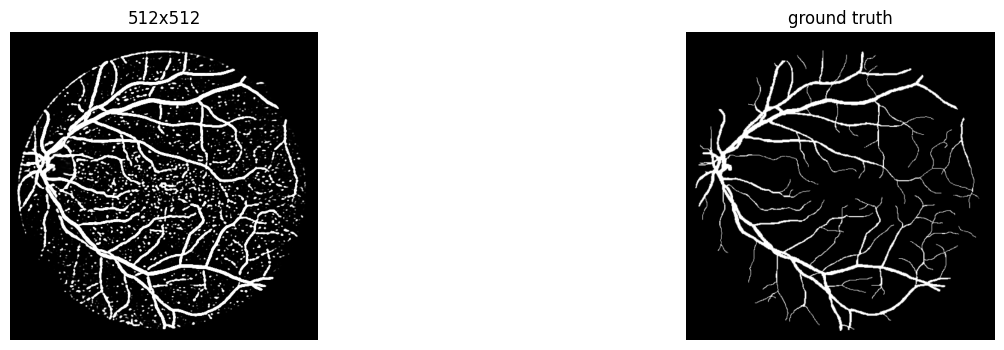

In [17]:
def evaluate_images_patched(image, mask, model, crop_size,device='cpu'):
    image = image.to(device)  # Move input to the correct device
    model = model.to(device)
    
    image_size = np.array(image.cpu()).shape # image is a tensor of shape (B, C, W, H)
    print(image_size)
    x_splits = (int)(image_size[2] / crop_size[0]) 
    y_splits = (int)(image_size[3] / crop_size[1])
    
    batch_size = image_size[0]
    
    output_images = torch.zeros(image_size)
    
    avg_loss = 0
    model.eval()
    x_size = crop_size[0]
    y_size = crop_size[1]
    
    
    print(x_splits)
    print(y_splits)
    for x in range(x_splits):
        for y in range(x_splits):
            main_image = TF.functional.crop(image,    x*x_size,y*y_size,x_size,y_size)
            
            pred = model(main_image)
            loss = torch.sigmoid(pred).detach().cpu()
            loss = (loss > 0.5).long()

            output_images[:, :, x*x_size:x*x_size+x_size, y*y_size: y*y_size+y_size] = loss
            avg_loss += loss.sum() / batch_size*x_splits*y_splits
            print(avg_loss)
            del main_image
    
    # make white all pixels over 0.5
    # output_images = torch.where(output_images < 0.53, torch.zeros_like(output_images), torch.ones_like(output_images))
    
    return output_images ,avg_loss




def evaluate_model(model, loss_fn, test_loader, device="cuda"):
    avg_loss = 0
    model = model.to(device)
    model.eval()        
    for dictionary in test_loader:
        X_batch = dictionary['image'].to(device)
        Y_batch = dictionary['vessel_mask'].to(device)

        # forward
        Y_pred = model(X_batch)
        loss = loss_fn(Y_batch, Y_pred)  # forward-pass

        # calculate metrics to show the user
        avg_loss += loss.item() / len(test_loader)
        
        
        del X_batch
        del Y_batch
    X_test, Y_test = next(iter(test_loader))
    model.to("cpu")
    # show intermediate results
    Y_hat = torch.sigmoid(model(X_test.to("cpu"))).detach().cpu()
    
    clear_output(wait=True)
    count = 1
    print(X_test[0].numpy().shape)
    for k in range(count):
        plt.subplot(1, 2, k+1)
        plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(1, 2, k+count*1+1)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.suptitle('- loss: %f' % ( avg_loss))
    plt.show()

# evaluate_model(model, focal_loss, test_loader=test_loader)
image = next(iter(test_loader))

main = image["image"][:]
secondary = image["vessel_mask"][:]

transform = TF.ToPILImage()

size64 = 64
size128 = 128
size256 = 256
size512 = 512
device = "cpu"

images64, _ = evaluate_images_patched(main, secondary, model, crop_size=(size64,size64),device=device )
images128, _ = evaluate_images_patched(main, secondary, model, crop_size=(size128,size128),device=device )
images256, _ = evaluate_images_patched(main, secondary, model, crop_size=(size256,size256),device=device )
images512, _ = evaluate_images_patched(main, secondary, model, crop_size=(size512,size512),device=device )


fig, axs = plt.subplots(1, 2, figsize=(16, 4))  # You can change (1, 4) to (2, 2) for a 2x2 grid



axs[0].imshow(transform(images512[0]), cmap="gray")
axs[0].set_title('512x512')
axs[0].axis('off')

axs[1].imshow(transform(secondary[0]), cmap="gray")
axs[1].set_title('ground truth')
axs[1].axis('off')

# Display the full figure
plt.show()


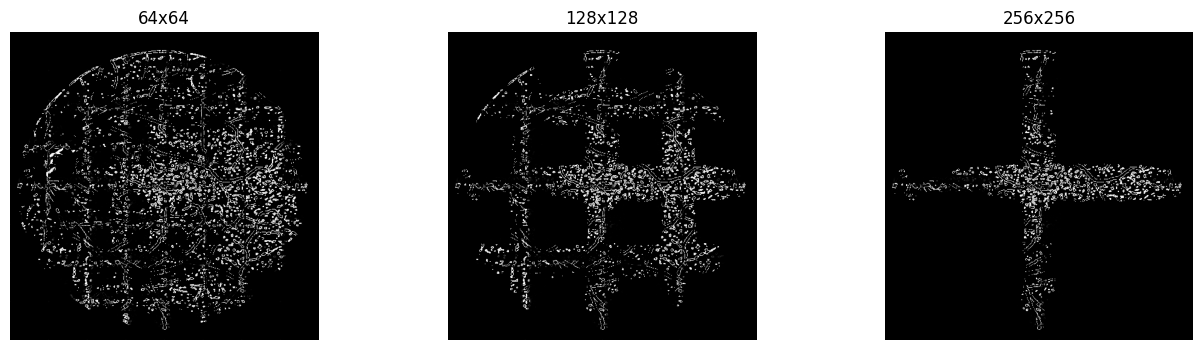

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))  # You can change (1, 4) to (2, 2) for a 2x2 grid

diff1 = images64[0] - images512[0]
diff2 = images128[0] - images512[0]
diff3 = images256[0] - images512[0]

# Display each image in a subplot
axs[0].imshow(transform(diff1), cmap="gray")
axs[0].set_title('64x64')
axs[0].axis('off')  # Turn off axis labels

axs[1].imshow(transform(diff2), cmap="gray")
axs[1].set_title('128x128')
axs[1].axis('off')

axs[2].imshow(transform(diff3), cmap="gray")
axs[2].set_title('256x256')
axs[2].axis('off')



# Display the full figure
plt.show()